In [1]:
import os 
import re 
import time
import json 
from statistics import mode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage 
from skimage.morphology import skeletonize
from skimage.morphology import binary_closing
import cv2
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from sklearn.neighbors import KernelDensity
from sklearn.metrics.pairwise import euclidean_distances
from scipy.signal import argrelextrema
from sklearn.cluster import KMeans

NOTES: 
- consider fitted line instead of straight for row line 
- [!] try out DocEnTr for preprocessing 
- consider: differentiating between top and bottom >>> should not be necessary 
- consider: minimum number of contour centers for a row to be considered: done, set to 2
- catchment area for sorting corners into rows: potetial problem with rounding: done
- [!] some of the pages don't have a seg file
- dynamic minimum distance between row lines based on some deviation from the mode: rely on text line detection instead 
- FOR USING TEXT LINES: rely on the corners that are predicted with the existing method. Create extra points that are inbetween the corners (eg every 50 pixels). Then create points that are midway between every column pair, for every point in that column. Use coordinates from bounding box to identify what points they are closest to: this is a proxy for the location of the text line. Then crop the entire cell(s) - if text line prediction spans multiple cells, cut by column. The height of the crop should be easy to infer

In [3]:
def display_plt(img, bgr2rgb:bool=False, bw:bool=False):
    fig, ax = plt.subplots(figsize=(10,10))
    if bgr2rgb:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if bw:
        # img = 1 - img 
        ax.imshow(img, cmap="binary")
    else:
        ax.imshow(img)
    ax.axis("off")
    fig.tight_layout()
    return plt.show()

def display_cv2(img, name:str='img'):
    """
    press "q" to close window 
    """
    cv2.startWindowThread()
    cv2.imshow(name, img)
    # cv2.moveWindow(name, 1,0 )

    # wait until q is pressed 
    if cv2.waitKey(0) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
    cv2.waitKey(1)
    return 

In [4]:
class crop_cells():
    def __init__(self, img_name, path2imgs, path2segs, error_log, 
        segmentation_inspection, path2crops, home_dir):

        self.PATH2IMGS = path2imgs
        self.PATH2SEGS = path2segs
        self.cell_crops_folder = path2crops
        self.log = error_log
        self.save_segmented_folder = segmentation_inspection
        self.HOME = home_dir
        self.img_name = img_name 
        self.img_file_type = self.img_name.split(".")[-1]
        self.seg_name = re.sub(f".{self.img_file_type}", ".png", self.img_name)
        self.img = cv2.imread(os.path.join(self.PATH2IMGS, self.img_name))
        self.seg = cv2.imread(os.path.join(self.PATH2SEGS, self.seg_name))
        self.img_merged = self.preprocess_contrast(self.img)[0]
        self.img_gray = self.preprocess_contrast(self.img)[1]
        self.img_binary = self.preprocess_contrast(self.img)[2]
        
        self.HEIGHT = self.img.shape[0]
        self.WIDTH = self.img.shape[1]
        self.mask = np.zeros((self.HEIGHT, self.WIDTH))
        self.row_lines = None
        self.number_of_rows = None
        self.mode_number_columns = None 
        self.corners = None 
        self.interpolated_corners = None
        self.cols = None 
        
    def preprocess_contrast(self, \
                            img:np.ndarray, \
                            k1:tuple=(11,11), \
                            k2:tuple=(5,5), \
                            p1:int=9, \
                            p2:int=5
                           ):
        """
        Splits {img} into its three channels and preprocesses them separately 
        Returns
            Three versions of the image: 
                1. only merged (still three channels)
                2. {merged} in gray scale
                3. binary (cv2.threshold() on {merged})
        """
        # split {img} into its three channels 
        (B, G, R) = cv2.split(img)
        
        B = cv2.equalizeHist(B)
        # G = cv2.equalizeHist(G)
        # R = cv2.equalizeHist(R)

        B = cv2.GaussianBlur(B, k1, 0)
        thB = cv2.adaptiveThreshold(B,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                                       cv2.THRESH_BINARY,p1,p2)
        
        G = cv2.GaussianBlur(G, k1, 0)
        thG = cv2.adaptiveThreshold(G,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                                       cv2.THRESH_BINARY,p1,p2)

        R = cv2.GaussianBlur(R, k1, 0)
        thR = cv2.adaptiveThreshold(R,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                                       cv2.THRESH_BINARY,p1,p2)

        # merge channels back together 
        merged = cv2.merge([thB, thG, thR])
        # convert to one channel / grayscale 
        gray = cv2.cvtColor(merged, cv2.COLOR_BGR2GRAY)
        # similarly binarize 
        gray = cv2.GaussianBlur(gray, k2, 0)
        _, binary = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        
        return merged, gray, binary
    
    def points_of_interest(self, img:np.ndarray, H1:int=100, min_c_size:int=100, \
                           thres_floor2ceiling:float=4e-3):
        """
        Detects contours in {img}. 
        The y values for row lines are chosen based on how many other centers 
        are in within a threshold from them.
        Returns
            1. Center coordinates for found contours
            2. Neighborhoods (bands) of contour centers
        """
        def contour_width_control(cnt:np.ndarray, T:int=10):
            """
            Checks that the size of (mibAreaRect) {cnt} is at least {T} in 
            any direction
            Returns
                False if all directions are above threshold ({cnt} is good to go)
                and True otherwise 
            """
            rect = cv2.minAreaRect(cnt) # Box2D structure: 
            # ... (center (x,y), (width, height), angle of rotation). 
            box = cv2.boxPoints(rect).astype(int) # converts {rect} into simple box
            A = euclidean_distances(box, box) # shape: len({box}) x len({box})
            # remove diagonal elements 
            A = A[~np.eye(A.shape[0], dtype=bool)].reshape(A.shape[0], -1)
            return np.any(A < T)

        # img_copy = img.copy() # INSPECTION 
        _, gray, _ = self.preprocess_contrast(img)
        # invert img
        gray = 255 - gray
        # detect edges with Canny()
        edges = cv2.Canny(gray, H1, H1*2, L2gradient=True)
        contours, _ = cv2.findContours(edges, cv2.RETR_TREE, \
                                               cv2.CHAIN_APPROX_SIMPLE)

        contours_poly = [None]*len(contours)
        centers = [None]*len(contours)

        for i, c in enumerate(contours):
            if cv2.contourArea(c) > min_c_size and not contour_width_control(c):
                contours_poly[i] = cv2.approxPolyDP(c, 3, True)
                centers[i], _ = cv2.minEnclosingCircle(contours_poly[i])
                # cv2.drawContours(img_copy, contours, i, (0, 0, 255), 1) # INSPECTION
                # cv2.circle(img_copy, (int(centers[i][0]), int(centers[i][1])), 1, (255,0,0), 10) # INSPECTION
            else:
                continue

        # display_cv2(img_copy) # INSPECTION 
        centers = [c for c in centers if c is not None]
        
        # x and y coordinates for centers 
        xs = [x[0] for x in centers]
        ys = [y[1] for y in centers]
        xys = np.array([xs, ys]).T
        xys = xys[xys[:, 1].argsort()]
        xys = xys.astype(int)
        
        # create a band around the detected centers for what constitutes a neighborhood 
        # the y values that has the most centers in their band is considered a good candidate 
        THRESHOLD =  np.round(thres_floor2ceiling * self.HEIGHT) # distance to floor / ceiling 
        neighbors_dict = {}

        for e, (_,y) in enumerate(xys):
            neighbors_dict[e] = np.argwhere((xys[:,1] <= y + THRESHOLD) \
                                            & (xys[:,1] >= y - THRESHOLD))
        # enforce at least two points in neighborhood 
        neighbors_dict = {k:v for k,v in neighbors_dict.items() if len(v) >= 2}
        neighbors_dict_sorted = sorted(neighbors_dict.items(), key=lambda n: \
                                       len(n[1]),reverse=True)
        # print(neighbors_dict_sorted)
        return xys, neighbors_dict_sorted   
    
    def between_candidates(self, a, e, t):
        """
        Returns True if {e}-{t} <= {a} <= {e}+{t} is True 
        Args
            a: aspirant point to be tested
            e: established points accepted as candidates 
            t: threshold 
        """
        e = np.array(e)
        return any((a <= e + t) & (a >= e - t))    

    def get_lines(self, points:np.ndarray, neighbors:list, \
                  min_dist_rows:float=0.02):
        """
        Proposes y values for rows 
        Returns
            List of candidate rows 
        """
        if (len(points) < 2) or (not neighbors):
            with open(self.log, mode="a") as f:
                f.write(f"No horizontal rows,{self.img_name}" + "\n")
            raise IndexError("No row lines ") 
        else:
            #  minimum distance between horisontal lines 
            THRESHOLD = np.round(min_dist_rows * self.HEIGHT ) # 2e-2 * HEIGHT)
            candidate_ys = []
            # idx4candidates = []
            candidate_ys.append(points[neighbors[0][0], 1])
            # idx4candidates.append(neighbors[0][1])

            for i in range(1, len(neighbors)):
                c = neighbors[i][0]
                c_y = points[c, 1]
                if not self.between_candidates(c_y, candidate_ys, THRESHOLD):
                    candidate_ys.append(c_y)
                    # idx4candidates.append(neighbors[i][1])
                else:
                    continue

        return candidate_ys   
    
    def get_rows(self):
        """
        Sorts and selects the detected lines into final rows 
        """
        img_end_right = self.WIDTH // 10
        img_end_left = self.WIDTH // 5
        img = self.img[:, img_end_left:img_end_right*4] # focus on left side of page 
        # display_cv2(img)
        points, neighbors = self.points_of_interest(img)
        lines = self.get_lines(points, neighbors)
        lines = sorted(lines)
        # find pair wise mean between two lines 
        lines = [np.mean([lines[i], lines[i+1]]).astype(int) \
                 for i, _ in enumerate(lines) if i < len(lines) - 1]
        self.row_lines = np.round(lines).astype(int)
        self.number_of_rows = len(lines)
        return 
    
    def mask_vertical_lines(self):
        """
        Draws the detected vertical lines on self.mask
        NOTE: potential for improvement by tweaking parameters 
        """
        KERNEL_HEIGHT = self.HEIGHT//3
        DILATION_KERNEL_HEIGHT = self.HEIGHT//10
        DILATION_KERNEL_WIDTH = 20 
        
        img = cv2.cvtColor(self.seg, cv2.COLOR_BGR2GRAY)
        _, img = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

        vertical_kernel= cv2.getStructuringElement(cv2.MORPH_RECT, (1, KERNEL_HEIGHT))

        detect_vertical = cv2.morphologyEx(img, cv2.MORPH_OPEN, 
                                            vertical_kernel, iterations=1)

        cntsV, _ = cv2.findContours(detect_vertical, cv2.RETR_EXTERNAL, 
                                    cv2.CHAIN_APPROX_SIMPLE)

        for c in cntsV:
            cv2.drawContours(self.mask, [c], -1, (255), thickness=cv2.FILLED)

        # dilate mask to close potential gaps - smooths out a few cases 
        dilation_kernel = np.ones((DILATION_KERNEL_HEIGHT, DILATION_KERNEL_WIDTH), np.uint8)
        self.mask = cv2.dilate(self.mask, dilation_kernel, iterations=1)
        self.mask = self.mask // 255 # "binarize" - skimage expects this format
        # skeletonize 
        self.mask = skimage.morphology.skeletonize(self.mask)
        self.mask = skimage.morphology.binary_closing(self.mask) # apply closing 
        # the img is inverted when looking for points of interest 
        self.mask = np.array(self.mask * 255).astype(np.float64) # opencv expects this format 
        # experiment: thicken the vertical line for better corner detection 
        # >> shifts the corner, so not a good idea ! 
        # for w in cv2.findNonZero(self.mask):
            # print(w[0])
            # idx = w[0]
            # self.mask[idx[1], idx[0]-1:idx[0]+2] = 255
        return 
    
    def get_corners(self, T:int=5):
        """
        Draws both horizontal and vertical lines on self.mask
        Args
            T: threshold for acceptable distance from corner to any row line.
                If a corner is not within this distance to any row line, it is 
                discarded
        Returns 
            corners from the Harris detector 
        """
        # run the two functions for vertical and horizontal lines
        # - rerun every function every time instead of trying to save a bit of time 
        self.mask_vertical_lines()
        self.get_rows()
            
        for y in self.row_lines:
            cv2.line(self.mask, (1, y), (self.WIDTH-1, y), (255), thickness=1)
            
        coords = corner_peaks(corner_harris(self.mask), min_distance=50, threshold_rel=0.51)
        coords_subpix = corner_subpix(self.mask, coords, window_size=100, alpha=0.51)
        coords_subpix = np.array([c for c in coords_subpix if any(abs(self.row_lines-c[0]) < T)])
        self.corners = np.round(coords_subpix).astype(int)
        
        cols = list(self.corners[:,0])
        self.mode_number_columns = mode([cols.count(x) for x in set(cols)])
        return        
        
    def list_nearest_from_list(self, l1:list, l2:list):
        """
        Returns the nearest item in {l1} for every item in {l2}
        Example
            l1 = [1, 4, 11, 20, 25]; l2 = [3, 10, 20]
            Returns
                [4, 11, 20]
        """
        return list(map(lambda y:min(l1, key=lambda x:abs(x-y)), l2))

    def mode_column_width(self, row_dict:dict, idx1:int, idx2:int):
        """
        Returns the mode of the space (# pixels) between two corner columns
        Args
            row_dict: dict row as key and a list of corresponding corners as value
            idx1, idx2: indices for the column 
        """
        res = []
        for r in row_dict:
            corners = row_dict[r]
            corners = corners[corners[:, 1].argsort()] 
            try:
                dist = np.linalg.norm(corners[idx1] - corners[idx2])
                res.append(dist.astype(int))
            except:
                IndexError

        return mode(res)

    def interpolate_grid(self, T:int=5):
        """
        Approximates "missing" self.corners 
        Args
            T: threshold distance to row line 
        """
        # create dict for corners at given row 
        corners_in_row_dict = {r : self.corners[np.where((r - T <= self.corners[:,0]) \
                                                         & (self.corners[:,0] <= r + T))] \
                               for r in self.row_lines}
        # compute the number of corners for that row 
        row_len = {k : len(v) for k,v in corners_in_row_dict.items()}
        assert sum(row_len.values()) == len(self.corners), \
        "Sum of corners in rows did not sum to total number of rows" # sanity check 
        # sort rows into the two categories 
        rows_to_interpolate = [k for k,v in row_len.items() \
                               if v != self.mode_number_columns]
        # print(rows_to_interpolate)
        complete_rows = [k for k,v in row_len.items() \
                         if v == self.mode_number_columns]
        
        if rows_to_interpolate:
            # find idx of nearest complete-incomplete row pair to indicate column number 
            min_dist = self.list_nearest_from_list(complete_rows, rows_to_interpolate)

            interpolated_corners = []
            # iterate through the pairs of incomplete rows and the nearest complete
            for _idx, full_row_idx in enumerate(min_dist): # idx for min dist 
                incomplete_row_idx = rows_to_interpolate[_idx]
                incomplete_row = corners_in_row_dict[incomplete_row_idx].copy()
                incomplete_row = incomplete_row[incomplete_row[:, 1].argsort()] 
                # print(f"row to be interpolated: {incomplete_row_idx}")
                full_row = corners_in_row_dict[full_row_idx].copy() # corners in complete row 
                full_row = full_row[full_row[:, 1].argsort()] 

                # map the corners that we have - to find out which we do not have 
                cols_present = [np.argmin(np.linalg.norm(r - full_row, axis=1)) \
                                for r in incomplete_row]
                # map the cols to their x value in incomplete row list 
                cols_present_to_x = {pres : inc  for pres, inc in zip(cols_present, incomplete_row)} 
                cols_missing = [c for c in range(7) if c not in cols_present]
                # find the nearest neighbor for a missing corner to a known corner in a given row
                nearest_to_missing = self.list_nearest_from_list(cols_present, cols_missing)

                # start filling out the missing corners by interpolating 
                # from known locations and global mode of column width
                interpolated = np.zeros((len(cols_missing), 2))
                for i in range(len(cols_missing)):
                    width = self.mode_column_width(corners_in_row_dict, cols_missing[i], \
                                                   nearest_to_missing[i])
                    # find the x value of the nearest known corner in the same row 
                    nearest_known_x = cols_present_to_x[nearest_to_missing[i]][1]
                    if nearest_to_missing[i] < cols_missing[i]:
                        interpolated[i] = [incomplete_row_idx, nearest_known_x + width]
                    else:
                        interpolated[i] = [incomplete_row_idx, nearest_known_x - width]

                interpolated_corners.append(interpolated)

            self.interpolated_corners = np.concatenate(interpolated_corners, axis=0)
        return 

    def sort_corners_into_cols(self, T:int=5):
        """
        Sorts corners into columns based on what row they belong to and then 
        sorting left to right 
        """
        if self.corners is None:
            self.get_corners()
        if self.interpolated_corners is None:
            self.interpolate_grid()

        if self.interpolated_corners is not None:
            corners = np.concatenate((self.corners, self.interpolated_corners))
        else:
            corners = self.corners
        col0 = []
        col1 = []
        col2 = []
        col3 = []
        col4 = []
        col5 = []
        col6 = []

        corners_in_row_dict = {r : corners[np.where((r - T <= corners[:,0]) \
                                                            & (corners[:,0] <= r + T))] \
                                for r in self.row_lines}
        for _, v in corners_in_row_dict.items():
            v = v[v[:, 1].argsort()]
            col0.append(v[0])
            col1.append(v[1])
            col2.append(v[2])
            col3.append(v[3])
            col4.append(v[4])
            col5.append(v[5])
            col6.append(v[6])             

        self.cols = [np.array(col0), np.array(col1), np.array(col2),
                np.array(col3), np.array(col4), np.array(col5), np.array(col6)]
        return 
    
    def draw_and_show_corners(self, add_corners=None):
        # get corners 
        self.get_corners()
        self.interpolate_grid()
        self.sort_corners_into_cols()
        
        fig, ax = plt.subplots(figsize=(20,16))
        img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        
        # draw coordinates:     x                   y
        # ax.plot(self.corners[:, 1], self.corners[:, 0], '.r', markersize=10)
        for i, col in enumerate(self.cols):
            ax.plot(col[:, 1], col[:, 0], '+r', markersize=15)
            # for x, y in zip(col[:, 1], col[:, 0]):
            #     ax.text(x, y, str(i), c='g', size=15)

        if self.interpolated_corners is not None:
            ax.plot(self.interpolated_corners[:, 1], self.interpolated_corners[:, 0], \
                    # '.b', markersize=10)
                    '+r', markersize=15)
            
        if add_corners is not None:
            ax.plot(add_corners[:, 1], add_corners[:, 0], '.g', markersize=10)
            
        ax.axis('off')
        plt.savefig("/Users/jonasflotz/Desktop/mgr_advisory_board_meeting_010322/math.jpg")
        plt.show()
        return 
    
    def save_gray_with_corners(self, add_corners=None):
        self.get_corners()
        self.interpolate_grid()
        self.sort_corners_into_cols()

        fig, ax = plt.subplots(figsize=(20,16))
        # img = 255 - self.img_binary 
        img = skimage.color.gray2rgb(self.img_gray)
        
        ax.imshow(img)
        # draw coordinates:     x                   y
        # ax.plot(self.corners[:, 1], self.corners[:, 0], '.r', markersize=10)
        for i, col in enumerate(self.cols):
                ax.plot(col[:, 1], col[:, 0], '.r', markersize=10)
                for x, y in zip(col[:, 1], col[:, 0]):
                    ax.text(x, y, str(i), c='g', size=15)

        if self.interpolated_corners is not None:
            ax.plot(self.interpolated_corners[:, 1], self.interpolated_corners[:, 0], \
                    '.b', markersize=10)
            
        if add_corners is not None:
            ax.plot(add_corners[:, 1], add_corners[:, 0], '.g', markersize=10)
            
        ax.axis('off')
        plt.title(self.img_name)
        plt.savefig(os.path.join(self.save_segmented_folder, self.img_name),\
                   bbox_inches="tight")
        plt.close()

    def crop(self, dict_name:int=round(time.time()), margin:int=10):
        self.get_corners()
        self.interpolate_grid()
        self.sort_corners_into_cols()
        # create dict to store crop locations 
        crop_coordinates_dict = {} 

        for col_idx in range(4): # we only want the first 4 columns 
            col_left = self.cols[col_idx]
            col_right = self.cols[col_idx+1]
            for row_idx in range(len(col_left)-1): # ignore the bottom cell for now 
                c1 = int(col_left[row_idx, 0]-margin)
                c2 = int(col_left[row_idx+1,0]+margin)
                c3 = int(col_left[row_idx, 1]-margin)
                c4 = int(col_right[row_idx,1]+margin)

                crop = self.img[c1:c2, c3:c4]

                # crop_name = f"r{row_idx}c{col_idx}i{self.img_name}"
                crop_name = re.sub(f".{self.img_file_type}", "", self.img_name)
                crop_name = f"{crop_name}-c{col_idx}-r{row_idx}.{self.img_file_type}" 
                crop_coordinates_dict[crop_name] = [c1, c2, c3, c4]
                cv2.imwrite(os.path.join(self.cell_crops_folder, crop_name), crop)
        with open(os.path.join(self.HOME, "cropped-cells-dict", \
            str(dict_name))+".json", "w") as f:
            json.dump(crop_coordinates_dict, f)
        return 

In [ ]:
# ensure working directory 
# os.chdir("/Users/jonasflotz/Documents/Scripts/Mathiesen")
path2imgs = "data/raw/Mathiesen-single-pages"
path2segs = "mathiesen/segmentations"
error_file_path = "mathiesen/split_cells-log.txt"
segmentation_inspection_folder = "mathiesen/cell-segmentation-inspection"
ARUNet_path = "mathiesen/ARUNet-results"
cropped_cells_folder = "mathiesen/cropped-cells"
base_folder = "mathiesen"

results = [f for f in os.listdir(ARUNet_path) if f.endswith(".npy")]

# check that we have vertical lines segmentations for the text line predictions 
segmentation_folder = "/Users/jonasflotz/Documents/Scripts/Mathiesen/segmentations"
segs = [f for f in os.listdir(segmentation_folder) if f.endswith(".png")]
lines = [f for f in results if re.sub(".npy", ".png", f) in segs ]
# print("num. missing vertical line segmentations for this set: " 
#         f"{len(results) - len(lines)}")

# get corresponding img
lines0_name = lines[10]


# test_file = "8013620831-0029-b.jpg" # no interpolation, many rows 
# test_file = "8013620831-0049-t.jpg" # interpolation 
test_file = "8013620831-0533-t.jpg" # no interpolation, strange column  
# test_file = "8013620831-0340-t.jpg" # blank page
# test_file = "8013620831-0763-b.jpg" # tricky top
# test_file = "8013620831-0349-t.jpg"
# test_file = "8013620831-0096-b.jpg"
# test_file = "8013620831-0810-b.jpg"
# test_file = "8013620831-0031-t.jpg"
test_file = "8013620831-0314-b.jpg"
# test_img = cv2.imread(os.path.join(PATH2IMGS, test_file+".jpg"))
# test_seg = cv2.imread(os.path.join(PATH2SEGS, test_file+".png"))

img = crop_cells(test_file,
                 path2imgs,
                 path2segs,
                 error_file_path,
                 segmentation_inspection_folder,
                 cropped_cells_folder,
                 base_folder
                 )

# img.preprocess_contrast()
# img.get_corners()
# display_plt(img.mask)
# rows = img.get_rows()

# manual inspection 
# img.get_corners()
# mask = img.img_gray
# mask = skimage.color.gray2rgb(mask)
# fig, ax = plt.subplots(figsize=(20,16))
# ax.imshow(mask)
# ax.plot(img.corners[:, 1], img.corners[:, 0], '.r', markersize=15)
# ax.axis('off')
# plt.title(img.img_name)
# plt.show()

# img.crop(dict_name="test1")
img.draw_and_show_corners()
# img.save_binary_with_corners()

FileNotFoundError: [WinError 3] Den angivne sti blev ikke fundet: 'mathiesen/ARUNet-results'

In [14]:
# crop out single cell for advisory board presentation 
corners = [126, 250, 1085, 1301]
test_file = "8013620831-0314-b.jpg"
img0 = img.img[20:corners[0]+10, corners[2]:corners[3]]
cv2.imwrite("/Users/jonasflotz/Desktop/mgr_advisory_board_meeting_010322/crop00.jpg", img0)

True

In [13]:
os.getcwd()

'/Users/jonasflotz/Documents/Scripts/Mathiesen'

In [31]:
# IDEA FOR SORTING INTO ROWS
# we now the row lines, so we assign the coordinates to these row lines (once again)
# and sort them from left to right. 
# The sorting is done on the complete, interpolated set of coordinates, 
# so there shouldn't be any holes 
rows = img.row_lines
# c1 = img.corners
# c2 = img.interpolated_corners
corners = np.concatenate((img.corners, img.interpolated_corners))
T=5 

col0 = []
col1 = []
col2 = []
col3 = []
col4 = []
col5 = []
col6 = []

corners_in_row_dict = {r : corners[np.where((r - T <= corners[:,0]) \
                                                    & (corners[:,0] <= r + T))] \
                        for r in rows}
for _, v in corners_in_row_dict.items():
    v = v[v[:, 1].argsort()]
    col0.append(v[0])
    col1.append(v[1])
    col2.append(v[2])
    col3.append(v[3])
    col4.append(v[4])
    col5.append(v[5])
    col6.append(v[6])             

cols = [np.array(col0), np.array(col1), np.array(col2),
        np.array(col3), np.array(col4), np.array(col5), np.array(col6)]
cols

[array([[ 461.,  736.],
        [ 567.,  731.],
        [ 668.,  731.],
        [ 774.,  731.],
        [ 881.,  726.],
        [1034.,  723.],
        [1189.,  720.],
        [1297.,  717.],
        [1408.,  709.],
        [1516.,  706.],
        [1619.,  705.],
        [1721.,  701.],
        [1816.,  697.],
        [1920.,  697.],
        [2033.,  697.],
        [2140.,  695.],
        [2245.,  694.],
        [2346.,  693.],
        [2450.,  692.],
        [2554.,  691.],
        [2651.,  691.],
        [2746.,  690.]]),
 array([[ 461.,  870.],
        [ 567.,  865.],
        [ 668.,  865.],
        [ 774.,  865.],
        [ 881.,  846.],
        [1034.,  844.],
        [1189.,  841.],
        [1297.,  839.],
        [1409.,  838.],
        [1516.,  836.],
        [1619.,  834.],
        [1721.,  833.],
        [1816.,  831.],
        [1920.,  831.],
        [2033.,  831.],
        [2140.,  829.],
        [2245.,  828.],
        [2346.,  827.],
        [2450.,  826.],
        [2554.

In [28]:
# load in results from text line detection for visual inspection 
ARUNet_path = "/Users/jonasflotz/Documents/Scripts/Mathiesen/ARUNet-results"
base_folder = "/Users/jonasflotz/Documents/Scripts/Mathiesen"
line_txt_results = [f for f in os.listdir(ARUNet_path) if f.endswith(".npy")]

# check that we have vertical lines segmentations for the text line predictions 
segmentation_folder = "/Users/jonasflotz/Documents/Scripts/Mathiesen/segmentations"
segs = [f for f in os.listdir(segmentation_folder) if f.endswith(".png")]
overlap = [f for f in line_txt_results if re.sub(".npy", ".png", f) in segs ]
imgs = [re.sub(".npy", ".jpg", i) for i in overlap]
for i in imgs: # np.random.choice(imgs, 100):
    print(i)
    img = crop_cells(i,
                 path2imgs,
                 path2segs,
                 error_file_path,
                 segmentation_inspection_folder,
                 cropped_cells_folder,
                 base_folder)
    img.crop(dict_name=re.sub(".jpg", "",i))

8013620831-0828-b.jpg
8013620831-0355-t.jpg
8013620831-0035-b.jpg
8013620831-0035-t.jpg
8013620831-0355-b.jpg
8013620831-0348-t.jpg
8013620831-0049-t.jpg
8013620831-0194-t.jpg
8013620831-0351-b.jpg
8013620831-0314-b.jpg
8013620831-0031-t.jpg
8013620831-0031-b.jpg
8013620831-0351-t.jpg
8013620831-0314-t.jpg
8013620831-0348-b.jpg
8013620831-0033-b.jpg
8013620831-0353-t.jpg
8013620831-0353-b.jpg
8013620831-0033-t.jpg
8013620831-0034-b.jpg
8013620831-0816-t.jpg
8013620831-0354-t.jpg
8013620831-0354-b.jpg
8013620831-0034-t.jpg
8013620831-0829-b.jpg
8013620831-0356-b.jpg
8013620831-0036-t.jpg
8013620831-0036-b.jpg
8013620831-0829-t.jpg
8013620831-0810-t.jpg
8013620831-0352-t.jpg
8013620831-0032-b.jpg
8013620831-0032-t.jpg
8013620831-0352-b.jpg
8013620831-0030-t.jpg
8013620831-0758-t.jpg
8013620831-0350-b.jpg
8013620831-0029-b.jpg
8013620831-0349-t.jpg
8013620831-0349-b.jpg
8013620831-0350-t.jpg
8013620831-0624-t.jpg
8013620831-0030-b.jpg
8013620831-0758-b.jpg
8013620831-0628-t.jpg
8013620831

In [ ]:
errors = pd.read_csv(error_file_path, delimiter=",", names=['message', 'file'], )
error_files = errors['file'].to_list()

imgs = [i for i in os.listdir(path2imgs) if re.sub(".jpg", ".png", i) in \
        os.listdir(path2segs) and i not in error_files and i.endswith(".jpg")]

for i in np.random.choice(imgs, 100):
    print(i)
    img = crop_cells(i,
                 path2imgs,
                 path2segs,
                 error_file_path,
                 segmentation_inspection_folder)
    img.save_gray_with_corners()

8013620831-0639-t.jpg
8013620831-0236-t.jpg
8013620831-0722-b.jpg
8013620831-0156-b.jpg
8013620831-0488-t.jpg
8013620831-0729-b.jpg
8013620831-0362-b.jpg
8013620831-0262-b.jpg
8013620831-0678-t.jpg
8013620831-0681-b.jpg
8013620831-0262-b.jpg
8013620831-0458-b.jpg
8013620831-0083-b.jpg
8013620831-0605-b.jpg
8013620831-0032-t.jpg
8013620831-0252-t.jpg
8013620831-0369-b.jpg
8013620831-0751-b.jpg
8013620831-0059-t.jpg
8013620831-0673-t.jpg
8013620831-0132-t.jpg
8013620831-0643-b.jpg
8013620831-0425-b.jpg
8013620831-0281-b.jpg
8013620831-0626-t.jpg
8013620831-0376-t.jpg
8013620831-0703-t.jpg
8013620831-0781-b.jpg
8013620831-0307-t.jpg
8013620831-0571-b.jpg
8013620831-0777-b.jpg
8013620831-0781-t.jpg
8013620831-0644-t.jpg
8013620831-0117-b.jpg
8013620831-0292-b.jpg
8013620831-0484-t.jpg
8013620831-0541-t.jpg
8013620831-0661-t.jpg
8013620831-0141-b.jpg
8013620831-0444-b.jpg
8013620831-0409-t.jpg
8013620831-0059-t.jpg
8013620831-0067-t.jpg
8013620831-0187-b.jpg
8013620831-0376-b.jpg
8013620831

ValueError: min() arg is an empty sequence

In [18]:
errors = pd.read_csv(error_file_path, delimiter=",", names=['message', 'file'], )
error_files = errors['file'].to_list()
imgs = [i for i in os.listdir(path2imgs) if re.sub(".jpg", ".png", i) in \
        os.listdir(path2segs) and i not in error_files]
imgs

['8013620831-0468-t.jpg',
 '8013620831-0138-b.jpg',
 '8013620831-0615-b.jpg',
 '8013620831-0281-b.jpg',
 '8013620831-0650-b.jpg',
 '8013620831-0345-t.jpg',
 '8013620831-0794-t.jpg',
 '8013620831-0769-t.jpg',
 '8013620831-0239-b.jpg',
 '8013620831-0514-b.jpg',
 '8013620831-0551-b.jpg',
 '8013620831-0180-b.jpg',
 '8013620831-0495-t.jpg',
 '8013620831-0807-t.jpg',
 '8013620831-0044-t.jpg',
 '8013620831-0361-b.jpg',
 '8013620831-0324-b.jpg',
 '8013620831-0631-t.jpg',
 '8013620831-0159-t.jpg',
 '8013620831-0588-t.jpg',
 '8013620831-0409-b.jpg',
 '8013620831-0060-b.jpg',
 '8013620831-0530-t.jpg',
 '8013620831-0575-t.jpg',
 '8013620831-0258-t.jpg',
 '8013620831-0708-b.jpg',
 '8013620831-0199-t.jpg',
 '8013620831-0548-t.jpg',
 '8013620831-0220-t.jpg',
 '8013620831-0265-t.jpg',
 '8013620831-0770-b.jpg',
 '8013620831-0735-b.jpg',
 '8013620831-0319-b.jpg',
 '8013620831-0298-t.jpg',
 '8013620831-0121-t.jpg',
 '8013620831-0164-t.jpg',
 '8013620831-0385-t.jpg',
 '8013620831-0754-t.jpg',
 '8013620831

In [53]:
ex = [200, 400]
exx = list(np.array([[x - 10, x + 50] for x in ex ]).flatten())
exx

[190, 250, 390, 450]

# text line detection
- follow along the lines of what has already been done, but instead create the row lines j pixels below and i pixels above the "agreement" line (where the majority of blue dots are )

In [29]:
def load_corresponding_img(name:str) -> np.ndarray:
    """
    Takes name for text line result and returns corresponding img
    """
    img_folder = "/Users/jonasflotz/Documents/Scripts/Dataset/Mathiesen-single-pages"
    file_type = name.split(".")[-1]
    img_name = re.sub(f".{file_type}", ".jpg", name)
    img_path = os.path.join(img_folder, img_name)
    return cv2.imread(img_path)

def load_corresponding_vertical_segment(name:str) -> np.ndarray:
    """
    Takes name for text line result and returns corresponding vertical line predictions
    """
    img_folder = "/Users/jonasflotz/Documents/Scripts/Mathiesen/segmentations"
    file_type = name.split(".")[-1]
    img_name = re.sub(f".{file_type}", ".png", name)
    img_path = os.path.join(img_folder, img_name)
    return cv2.imread(img_path)

def load_and_preprocess_text_lines(name:str) -> np.ndarray:
    folder = "/Users/jonasflotz/Documents/Scripts/Mathiesen/ARUNet-results"
    arr = np.load(os.path.join(folder, name))
    arr = arr.reshape(arr.shape[1:])
    arr = (np.array(arr) * 255.999).astype(np.uint8)
    arr = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)
    _, arr = cv2.threshold(arr, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    dilation_kernel = np.ones((5, 9), np.uint8)
    arr = cv2.dilate(arr, dilation_kernel, iterations=1)
    # arr = arr // 255
    # arr = skimage.morphology.skeletonize(arr)
    # arr  = skimage.morphology.binary_closing(arr) # apply closing 
    # arr = np.array(arr * 255.999).astype(np.uint8)
    return arr 


# load in results from text line detection for visual inspection 
ARUNet_path = "/Users/jonasflotz/Documents/Scripts/Mathiesen/ARUNet-results"
results = [f for f in os.listdir(ARUNet_path) if f.endswith(".npy")]

# check that we have vertical lines segmentations for the text line predictions 
segmentation_folder = "/Users/jonasflotz/Documents/Scripts/Mathiesen/segmentations"
segs = [f for f in os.listdir(segmentation_folder) if f.endswith(".png")]
lines = [f for f in results if re.sub(".npy", ".png", f) in segs ]
print("num. missing vertical line segmentations for this set: " 
        f"{len(results) - len(lines)}")

# get corresponding img
lines0_name = lines[10]
print(lines0_name)
lines0 = load_and_preprocess_text_lines(lines0_name)
img0 = load_corresponding_img(lines0_name)
# get corresponding vertical line prediction 
seg0 = load_corresponding_vertical_segment(lines0_name)


num. missing vertical line segmentations for this set: 5
8013620831-0031-t.npy


In [38]:
img0 = load_corresponding_img(lines0_name)
# detect corners of text line predictions 
_h, _w = lines0.shape
copy = np.zeros((_h, _w, 3))
edges = cv2.Canny(lines0, 100, 200, L2gradient=True)
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, \
                                        cv2.CHAIN_APPROX_SIMPLE)

contours_poly = [None]*len(contours)
centers = [None]*len(contours)

for i, c in enumerate(contours):
    # if cv2.contourArea(c) > 10: # and not contour_width_control(c):
#     #     contours_poly[i] = cv2.approxPolyDP(c, 3, True)
#     #     centers[i], _ = cv2.minEnclosingCircle(contours_poly[i])
    cv2.drawContours(img0, contours, i, (0, 0, 255), thickness=2) # INSPECTION
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect).astype(int)
    cv2.drawContours(img0, [box], 0, (0, 255, 0), thickness=2)
    contours_poly[i] = cv2.approxPolyDP(c, 3, True)
    centers[i], _ = cv2.minEnclosingCircle(contours_poly[i])
    # cv2.drawContours(img_copy, contours, i, (0, 0, 255), 1) # INSPECTION
    cv2.circle(img0, (int(centers[i][0]), int(centers[i][1])), 2, (255,0,0), 10) # INSPECTION
    # else:
    #     continue

#         # cv2.circle(img_copy, (int(centers[i][0]), int(centers[i][1])), 1, (255,0,0), 10) # INSPECTION


display_cv2(img0) # INSPECTION 
# centers = [c for c in centers if c is not None]

In [28]:
display_cv2(res0)

# investigate missing segmentations 

In [10]:
import re 
import shutil 
path2imgs = "/Users/jonasflotz/Documents/Scripts/Dataset/Mathiesen-single-pages/"
path2segs = "/Users/jonasflotz/Documents/Scripts/Mathiesen/segmentations"
dest_folder = "/Users/jonasflotz/Documents/Scripts/Mathiesen/temp_folder"
list_imgs = os.listdir(path2imgs)
# list_imgs = [re.sub(".jpg", "", i) for i in list_imgs]
list_segs = os.listdir(path2segs)
# list_segs = [re.sub(".png", "", i) for i in list_segs]
missing = [i for i in list_imgs if re.sub(".jpg", ".png", i) not in list_segs]

for i in missing:
    old = os.path.join(path2imgs, i)
    new = os.path.join(dest_folder, i)
    shutil.copyfile(old, new)
    

In [82]:
cs = img.corners
# print(len(corners))
rl = img.row_lines
T = 2
#corners = np.array([c if \
#                    any((r - T <= cs[0]) | (cs[0] <= r + T)) for r in rl])
# cs = cs[np.where((r - T <= cs[:,0]) | (cs[:,0] <= r + T)) for r in rl] 
# any(rl - T <= cs[10][0])
dist = rl - cs[10][0]
any(abs(dist) < 2) 

True

In [47]:
cs[10]

array([2026,  912])

In [63]:
rl.T

array([ 223,  346,  477,  650,  772,  852,  942, 1035, 1120, 1212, 1315,
       1409, 1490, 1584, 1686, 1769, 1887, 2026, 2126, 2204, 2291, 2389,
       2489, 2592, 2695, 2785])

In [6]:
img = crop_cells(test_file,
                 path2imgs,
                 path2segs,
                 error_file_path)

display_cv2(img.img_binary)

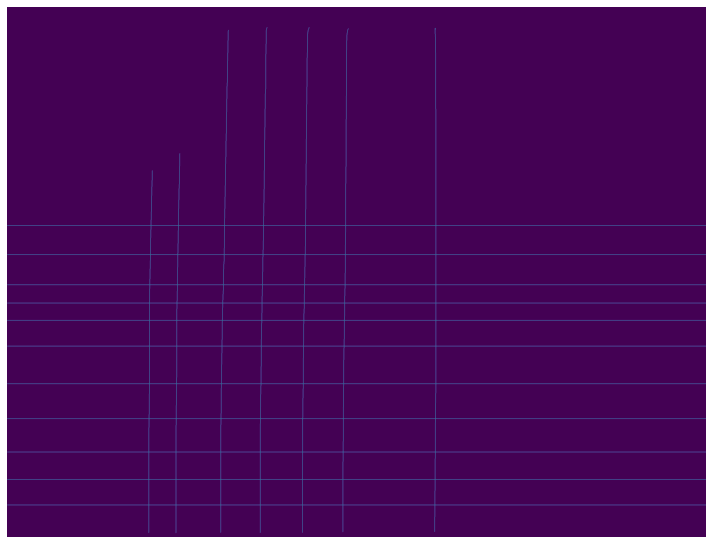

In [21]:
img = crop_cells(test_file,
                 path2imgs,
                 path2segs,
                 error_file_path,
                 segmentation_inspection_folder)
img.get_corners()
mask = img.mask
display_plt(mask)

# Misc 

In [ ]:
rl = img.row_lines
cs = img.corners
# create dict for corners at given row 
row_corners = {r : cs[np.where(cs[:,0] == r)] for r in rl}
# compute the number of corners for that row 
row_len = {r : len(cs[np.where(cs[:,0] == r)]) for r in rl}
assert sum(row_len.values()) == len(img.corners), "err" # sanity check 
rows_to_interpolate = [k for k,v in row_len.items() if v != img.mode_number_columns]
complete_rows = [k for k,v in row_len.items() if v == img.mode_number_columns]
print(rows_to_interpolate)
print(complete_rows)

In [127]:
# start with row that is closest to complete row 
def list_nearest_in_list(complete, incomplete):
    """
    returns the nearest complete row for every incomplete row 
    """
    return list(map(lambda y:min(complete, key=lambda x:abs(x-y)), incomplete))
min_dist = list_nearest_in_list(complete_rows, rows_to_interpolate)

# find idx of nearest points complete-incomplete to indicate column number 
min_idx = np.argmin(min_dist) # idx for min dist 
incomplete_row_idx = rows_to_interpolate[min_idx]
incomplete_row = row_corners[incomplete_row_idx].copy()
incomplete_row = incomplete_row[incomplete_row[:, 1].argsort()] 
print(f"row to be interpolated: {incomplete_row_idx}")
full_row_idx = min_dist[min_idx]
full_row = row_corners[full_row_idx].copy() # corners in complete row 
full_row = full_row[full_row[:, 1].argsort()] 
print(f"complete row: {full_row_idx}")

row to be interpolated: 267
complete row: 886


In [132]:
sorted([3,2,1])

[1, 2, 3]

In [128]:
min_dist

[886, 886, 886, 886, 886]

In [120]:
# map the corners that we have to find out which we do not have 
cols_present = [np.argmin(np.linalg.norm(r - full_row, axis=1)) for r in incomplete_row]
cols_missing = [c for c in range(7) if c not in cols_present]
nearest_to_missing = list_nearest_in_list(cols_present, cols_missing)
print(f"cols missing: {cols_missing}")
print(f"cols nearest to missing cols: {nearest_to_missing}")

cols missing: [1, 2, 4]
cols nearest to missing cols: [0, 3, 3]


In [125]:
interpolated = np.zeros((len(cols_missing), 2))
for i in range(len(cols_missing)):
    width = mode_column_width(row_corners, cols_missing[i], nearest_to_missing[i])
    nearest_known_x = full_row[nearest_to_missing[i]][1]
    if nearest_to_missing[i] < cols_missing[i]:
        interpolated[i] = [incomplete_row_idx, nearest_known_x + width]
    else:
        interpolated[i] = [incomplete_row_idx, nearest_known_x - width]
    
interpolated

array([[ 267.,  860.],
       [ 267., 1090.],
       [ 267., 1499.]])

In [46]:
img = crop_cells(test_file,
                 path2imgs,
                 path2segs,
                 error_file_path,
                 segmentation_inspection_folder)
img.get_corners()
rl = img.row_lines
cs = img.corners

In [20]:
def list_nearest_in_list(l1:list, l2:list):
    """
    Returns the nearest item in {l1} for every item in {l2}
    Example
        l1 = [1, 4, 11, 20, 25]; l2 = [3, 10, 20]
        Returns
            [4, 11, 20]
    """
    return list(map(lambda y:min(l1, key=lambda x:abs(x-y)), l2))

def mode_column_width(row_dict:dict, idx1:int, idx2:int):
    """
    Returns the mode of the space between two corner columns 
    """
    res = []
    for r in row_dict:
        corners = row_dict[r]
        corners = corners[corners[:, 1].argsort()] 
        try:
            dist = np.linalg.norm(corners[idx1] - corners[idx2])
            res.append(dist.astype(int))
        except:
            IndexError
        
    return mode(res)

def interpolate_grid(rl, cs, T:int=5):
    """
    Args
        rl: row lines
        cs: corners 
    """
    # create dict for corners at given row 
    corners_in_row_dict = {r : cs[np.where((r - T <= cs[:,0]) & (cs[:,0] <= r + T))] for r in rl}
    # corners_in_row_dict = {r : cs[np.where(cs[:,0] == r )] for r in rl}
    # compute the number of corners for that row 
    # row_len = {r : len(cs[np.where(cs[:,0] == r)]) for r in rl}
    row_len = {k : len(v) for k,v in corners_in_row_dict.items()}
    print(row_len) 
    assert sum(row_len.values()) == len(img.corners), \
    "Sum of corners in rows did not sum to total number of rows" # sanity check 
    # sort rows into the two categories 
    rows_to_interpolate = [k for k,v in row_len.items() if v != img.mode_number_columns]
    complete_rows = [k for k,v in row_len.items() if v == img.mode_number_columns]
    
    if rows_to_interpolate:
        # find idx of nearest complete-incomplete row pair to indicate column number 
        min_dist = list_nearest_in_list(complete_rows, rows_to_interpolate)

        interpolated_corners = []
        # iterate through the pairs of incomplete rows and the nearest complete
        for _idx, full_row_idx in enumerate(min_dist): # idx for min dist 
            incomplete_row_idx = rows_to_interpolate[_idx]
            incomplete_row = corners_in_row_dict[incomplete_row_idx].copy()
            incomplete_row = incomplete_row[incomplete_row[:, 1].argsort()] 
            # print(f"row to be interpolated: {incomplete_row_idx}")
            full_row = corners_in_row_dict[full_row_idx].copy() # corners in complete row 
            full_row = full_row[full_row[:, 1].argsort()] 

            # map the corners that we have to find out which we do not have 
            cols_present = [np.argmin(np.linalg.norm(r - full_row, axis=1)) for r in incomplete_row]
            # map the cols to their x value in incomplete row list 
            cols_present_to_x = {pres : inc  for pres, inc in zip(cols_present, incomplete_row)} 
            # print(f"cols present to x: {cols_present_to_x}")
            cols_missing = [c for c in range(7) if c not in cols_present]
            nearest_to_missing = list_nearest_in_list(cols_present, cols_missing)
            # print(f"nearest missing: {nearest_to_missing}")

            # start filling out the missing corners by interpolating from known locations and column width
            _interpolated = np.zeros((len(cols_missing), 2))
            for i in range(len(cols_missing)):
                width = mode_column_width(corners_in_row_dict, cols_missing[i], nearest_to_missing[i])
                nearest_known_x = cols_present_to_x[nearest_to_missing[i]][1] # incomplete_row[cols_present[i]][1]
                # print(f"nearest known: {nearest_known_x}")
                if nearest_to_missing[i] < cols_missing[i]:
                    _interpolated[i] = [incomplete_row_idx, nearest_known_x + width]
                else:
                    _interpolated[i] = [incomplete_row_idx, nearest_known_x - width]

            interpolated_corners.append(_interpolated)
    
        np.concatenate(interpolated_corners, axis=0)

    return 
 
# test_file = "8013620831-0533-t.jpg"
test_file = "8013620831-0049-t.jpg"
img = crop_cells(test_file,
                 path2imgs,
                 path2segs,
                 error_file_path,
                 segmentation_inspection_folder)
img.get_corners()
rl = img.row_lines
cs = img.corners

extra_corners = interpolate_grid(rl, cs)
extra_corners 

{261: 4, 466: 6, 572: 6, 671: 6, 777: 6, 881: 7, 1038: 7, 1197: 7, 1301: 7, 1411: 7, 1516: 7, 1621: 7, 1723: 7, 1822: 7, 1931: 7, 2033: 7, 2138: 7, 2247: 7, 2348: 7, 2450: 7, 2557: 7, 2653: 7, 2746: 7}


In [34]:
test_file = "8013620831-0533-t.jpg"
img = crop_cells(test_file,
                 path2imgs,
                 path2segs,
                 error_file_path,
                 segmentation_inspection_folder)
img.draw_and_show_corners()

# This might happen because the vertical lines do not touch the horizontal at all!

[2785]


ValueError: min() arg is an empty sequence

In [99]:
nearest_to_missing = list_nearest_in_list(cols_present, cols_missing)

In [122]:
def mode_column_width(row_dict, idx1, idx2):
    res = []
    for r in row_dict:
        corners = row_dict[r]
        corners = corners[corners[:, 1].argsort()] 
        try:
            dist = np.linalg.norm(corners[idx1] - corners[idx2])
            res.append(dist.astype(int))
        except:
            IndexError
        
    return mode(res)

# mode_column_width(row_corners, 0)

In [52]:
_row = row_corners[_comrow].copy() # corners in complete row 
print(_row)
_row[:,0] = _inrow # complete row with y from incomplete
print(_row)
print(row_corners[_comrow])
print(row_corners[_inrow])
# [c for c in _row if not any(np.linalg.norm(c - row_corners[_comrow], axis=0) < 10)]

[[ 886  847]
 [ 886 1494]
 [ 886 1292]
 [ 886 1086]
 [ 886  726]
 [ 886 1704]
 [ 886 2171]]
[[ 267  847]
 [ 267 1494]
 [ 267 1292]
 [ 267 1086]
 [ 267  726]
 [ 267 1704]
 [ 267 2171]]
[[ 886  847]
 [ 886 1494]
 [ 886 1292]
 [ 886 1086]
 [ 886  726]
 [ 886 1704]
 [ 886 2171]]
[[ 267  738]
 [ 267 2176]
 [ 267 1301]
 [ 267 1710]]


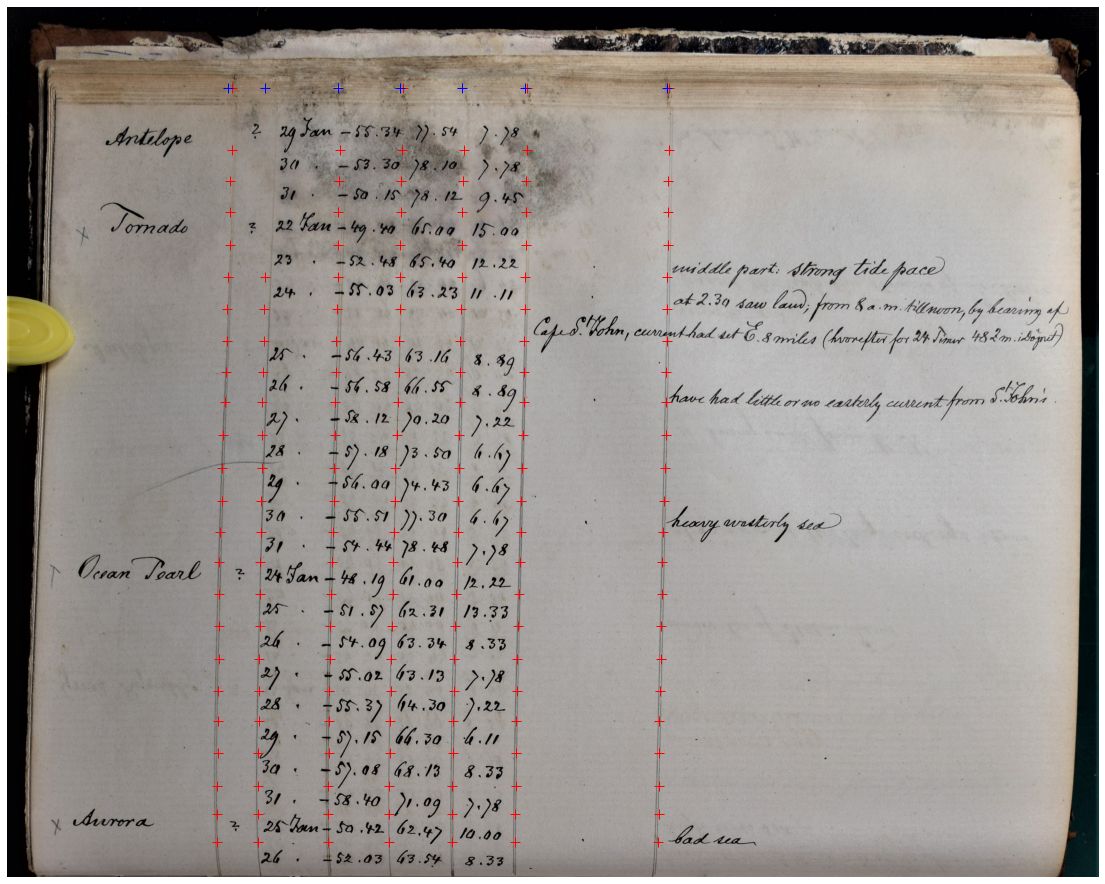

In [56]:
img = crop_cells(test_file,
                 PATH2IMGS,
                 PATH2SEGS)
img.draw_and_show_corners(_row)

In [51]:
np.linalg.norm(_row[0] - row_corners[_inrow], axis=1)

array([ 109., 1329.,  454.,  863.])

In [ ]:
# write iterative filler for incomplete rows based on mode distances:
# 

In [29]:
828 - 694

134

In [ ]:
row_corners

In [28]:
temp_cs = row_corners[2250]
temp_cs = temp_cs[temp_cs[:, 1].argsort()] 
temp_cs

array([[2250,  694],
       [2250,  828],
       [2250, 1059],
       [2250, 1261],
       [2250, 1468],
       [2250, 1675],
       [2250, 2146]])

In [17]:
for r in row_corners:
    print(r)
    break

267


In [78]:
# mode(list(img.corners[:,0]), key=list(img.corners[:,0]).count)
c = list(img.corners[:,0])
mode([c.count(x) for x in set(c)])

7

In [24]:
cs0 = cs[np.argwhere(cs[:,0] == rl[0])]
len(cs0)

4

In [41]:
row_len

{267: 4,
 469: 6,
 572: 6,
 673: 6,
 782: 6,
 886: 7,
 992: 7,
 1098: 7,
 1199: 7,
 1299: 7,
 1408: 7,
 1516: 7,
 1623: 7,
 1727: 7,
 1825: 7,
 1931: 7,
 2037: 7,
 2145: 7,
 2250: 7,
 2348: 7,
 2452: 7,
 2561: 7,
 2654: 7,
 2747: 7}

In [33]:
row_len_sum == len(img.corners)

True

In [40]:
display_cv2(test_img)

In [3]:
def display_plt(img, bgr2rgb:bool=False, bw:bool=False):
    fig, ax = plt.subplots(figsize=(10,10))
    if bgr2rgb:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if bw:
        # img = 1 - img 
        ax.imshow(img, cmap="binary")
    else:
        ax.imshow(img)
    ax.axis("off")
    fig.tight_layout()
    return plt.show()

def display_cv2(img, name:str='img'):
    """
    press "q" to close window 
    """
    cv2.startWindowThread()
    cv2.imshow(name, img)
    # cv2.moveWindow(name, 1,0 )

    # wait until q is pressed 
    if cv2.waitKey(0) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
    cv2.waitKey(1)
    return 

# Horizontal

In [19]:
def return_merged_thres(img):
    (B, G, R) = cv2.split(img)
    B = cv2.equalizeHist(B)
    # G = cv2.equalizeHist(G)
    # R = cv2.equalizeHist(R)
    
    k1 = (11,11)
    k2 = (5,5)
    p1 = 9
    p2 = 5
    
    # display_cv2(B)
    # B = cv2.equalizeHist(B)
    # display_cv2(B)
    B = cv2.GaussianBlur(B, k1, 0)
    thB = cv2.adaptiveThreshold(B,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                                   cv2.THRESH_BINARY,p1,p2)
    # display_cv2(thB)
    # cv2imshow(thB)
    G = cv2.GaussianBlur(G, k1, 0)
    # _, thG = cv2.threshold(Gblur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    thG = cv2.adaptiveThreshold(G,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                                   cv2.THRESH_BINARY,p1,p2)
    # thG = cv2.equalizeHist(thG)
    # cv2imshow(thG)
    R = cv2.GaussianBlur(R, k1, 0)
    thR = cv2.adaptiveThreshold(R,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                                   cv2.THRESH_BINARY,p1,p2)
    # thR = cv2.equalizeHist(thR)
    # cv2imshow(thR)
    # merge channels back together 
    merged = cv2.merge([thB, thG, thR])
    # convert to one channel / grayscale 
    gray = cv2.cvtColor(merged, cv2.COLOR_BGR2GRAY)
    # similarly binarize 
    gray = cv2.GaussianBlur(gray, k2, 0)
    # thC = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
    #                                cv2.THRESH_BINARY,p1,2)
    
    _, thC = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return merged, gray, thC

# test_img = cv2.imread(os.path.join(PATH2IMGS, test_file+".jpg"))
# m, g, t = return_merged_thres(test_img)

# display_cv2(g)

In [20]:
def points_of_interest(img:np.ndarray, HEIGHT:int, H1:int=100):
    merged, gray, thres = return_merged_thres(img)
    gray = 255 - gray
    edges = cv2.Canny(gray, H1, H1*2, L2gradient=True)
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, \
                                           cv2.CHAIN_APPROX_SIMPLE)

    contours_poly = [None]*len(contours)
    centers = [None]*len(contours)

    for i, c in enumerate(contours):
        if cv2.contourArea(c) > 70:
        # print(cv2.contourArea(c))
            contours_poly[i] = cv2.approxPolyDP(c, 3, True)
            centers[i], _ = cv2.minEnclosingCircle(contours_poly[i])
        else:
            continue
    centers = [c for c in centers if c is not None]

    for i in range(len(centers)):
    # cv.drawContours(drawing, contours_poly, i, color)
    # cv2.rectangle(img, (int(boundRect[i][0]), int(boundRect[i][1])), \
    #              (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), (0,0,255), 2)
        cv2.circle(img, (int(centers[i][0]), int(centers[i][1])), 1, (0,0,255), 5)
        # cv2.drawContours(img, contours_poly, -1, (0,0,255), 3)
    
    # display_cv2(img)
    
    xs = [x[0] for x in centers]
    ys = [y[1] for y in centers]
    xys = np.array([xs, ys]).T
    xys = xys[xys[:, 1].argsort()]
    xys = xys.astype(int)

    THRESHOLD =  np.round(4e-3 * HEIGHT) # distance to floor / ceiling 
    neighbors_dict = {}

    for e, (_,y) in enumerate(xys):
        neighbors_dict[e] = np.argwhere((xys[:,1] <= y + THRESHOLD) \
                                        & (xys[:,1] >= y - THRESHOLD))
        
    neighbors_dict_sorted = sorted(neighbors_dict.items(), key=lambda n: \
                                   len(n[1]),reverse=True)
    return xys, neighbors_dict_sorted      
    # return 
# test_img = cv2.imread(os.path.join(PATH2IMGS, test_file+".jpg"))
# _h, _w, _ = test_img.shape 
# _ = points_of_interest(test_img, _h)
# display_cv2(g)

In [21]:
def between_candidates(a, e, t):
    """
    Returns True if {e}-{t} <= {a} <= {e}+{t} is True 
    a: aspirant point to be tested
    e: established points accepted as candidates 
    t: threshold 
    """
    e = np.array(e)
    return any((a <= e + t) & (a >= e - t))    

def get_lines(points:np.ndarray, neighbors:list, HEIGHT:int):
    #  minimum distance between horisontal lines 
    THRESHOLD = np.round(0.025 * HEIGHT ) # 2e-2 * HEIGHT)
    candidate_ys = []
    idx4candidates = []
    candidate_ys.append(points[neighbors[0][0], 1])
    idx4candidates.append(neighbors[0][1])

    for i in range(1, len(neighbors)):
        c = neighbors[i][0]
        c_y = points[c, 1]
        print(c_y, candidate_ys, THRESHOLD)
        if not between_candidates(c_y, candidate_ys, THRESHOLD):
            candidate_ys.append(c_y)
            idx4candidates.append(neighbors[i][1])
        else:
            continue
    
    return candidate_ys    

In [22]:
def main(img:np.ndarray, HEIGHT:int, WIDTH:int):
    WIDTH_half = WIDTH // 2  
    # resize just to make it manageable
    # img = cv2.resize(img, (WIDTH, HEIGHT), interpolation=cv2.INTER_LANCZOS4)
    img = img[:, WIDTH_half//5:WIDTH_half] # focus on left side of page 

    # img1, img2 = split_img(img)
    points, neighbors = points_of_interest(img, HEIGHT)
    # points2, neighbors2 = points_of_interest(img2, HEIGHT)

    lines = get_lines(points, neighbors, HEIGHT)
    # lines2 = get_lines(points2, neighbors2, HEIGHT)
    return sorted(lines)

In [ ]:
test_img = cv2.imread(os.path.join(PATH2IMGS, test_file+".jpg"))
_h, _w, _ = test_img.shape 
l = main(test_img, _h, _w)
mid = [np.mean([l[i], l[i+1]]).astype(int) for \
       i, _ in enumerate(l) if i < len(l) - 1]
for y in mid:
    cv2.line(test_img, (1, y), (_w-1, y), (255), thickness=2)
#     break


display_cv2(test_img)

# from predictions to vertical lines 

In [9]:
# INFLUENTIAL PARAMETERS
# vertical_kernel
# dilation_kernel()

test_img = cv2.imread(os.path.join(PATH2IMGS, test_file+".jpg"))
test_seg = cv2.imread(os.path.join(PATH2SEGS, test_file+".png"))

img = cv2.cvtColor(test_seg, cv2.COLOR_BGR2GRAY)
_, img = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
_h, _w = img.shape 
mask = np.zeros((_h, _w))

vertical_kernel= cv2.getStructuringElement(cv2.MORPH_RECT, (1, _h//3))

detect_vertical = cv2.morphologyEx(img, cv2.MORPH_OPEN, 
                                    vertical_kernel, iterations=1)

cntsV, _ = cv2.findContours(detect_vertical, cv2.RETR_EXTERNAL, 
                            cv2.CHAIN_APPROX_SIMPLE)

for c in cntsV:
    cv2.drawContours(mask, [c], -1, (255), thickness=cv2.FILLED)
    
# display_cv2(mask)

# dilate mask to close potential gaps - smooths out a few cases 
dilation_kernel = np.ones((_h//10,20), np.uint8)
mask = cv2.dilate(mask, dilation_kernel, iterations=1)
mask = mask // 255 # "binarize" - skimage expects this format
# # skeletonize 
mask = skimage.morphology.skeletonize(mask)
mask = skimage.morphology.binary_closing(mask) # apply closing 
# skel = 1 - skel
mask = np.array(mask * 255).astype(np.float64) # opencv expects this format 

# test_img[np.argwhere(skel == 1)] = [0,0,255]

# display_plt(skel, bw=True)
# display_cv2(test_img)

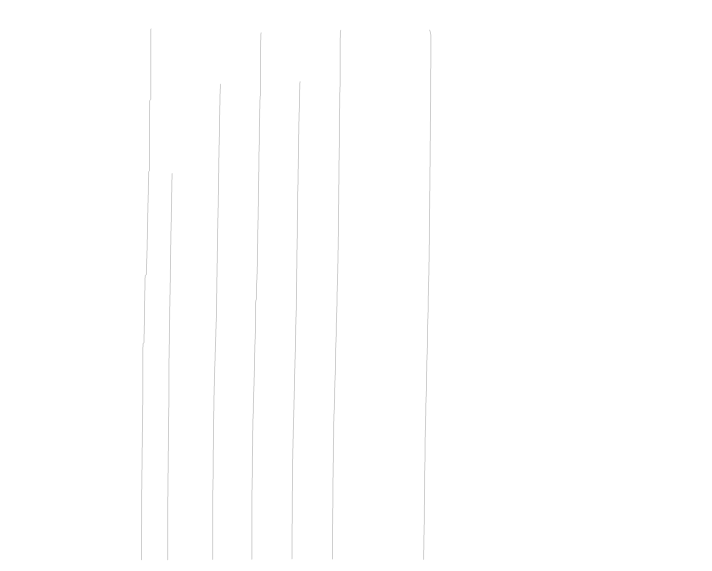

In [10]:
display_plt(mask, bw=True)

In [5]:
display_cv2(mask)

# combine horizontal and vertical 

In [11]:
for y in mid:
    cv2.line(mask, (1, y), (_w-1, y), (255), thickness=2)

display_cv2(mask)

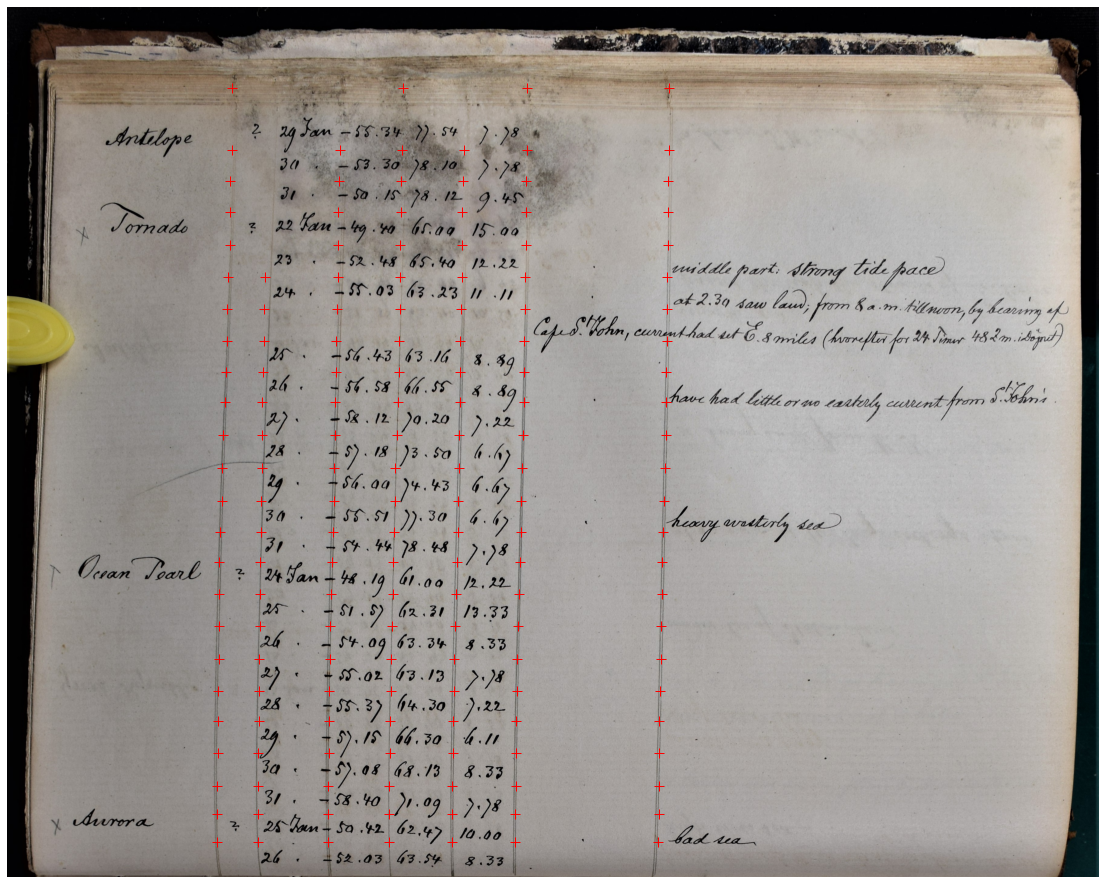

In [12]:
test_img = cv2.imread(os.path.join(PATH2IMGS, test_file+".jpg"))

coords = corner_peaks(corner_harris(mask), min_distance=70, threshold_rel=0.51)
coords_subpix = corner_subpix(mask, coords, window_size=10, alpha=0.51)

fig, ax = plt.subplots(figsize=(20,16))
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
ax.imshow(test_img, cmap=plt.cm.gray)
# ax.plot(coords[:, 1], coords[:, 0], '.b', markersize=3)
ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=10)
ax.axis('off')
# plt.show()
plt.show()

# grid completion 

In [ ]:
# split into rows 

In [13]:
len(mid)

24

In [63]:
len(ll)

25

In [51]:
enumerate(ll)

# experiments

In [7]:
test_img = cv2.imread(os.path.join(PATH2IMGS, test_file+".jpg"))
img, _ = return_merged_thres(test_img)

In [10]:
H1 = 100
edges = cv2.Canny(img, H1, H1*2, L2gradient=True)
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contours_poly = [None]*len(contours)
boundRect = [None]*len(contours)
centers = [None]*len(contours)
radius = [None]*len(contours)

for i, c in enumerate(contours):
    # print(cv2.contourArea(c))
    if cv2.contourArea(c) < 1e-2 * _h:
        contours_poly[i] = cv2.approxPolyDP(c, 3, True)
        boundRect[i] = cv2.boundingRect(contours_poly[i])
        centers[i], radius[i] = cv2.minEnclosingCircle(contours_poly[i])
    else:
        continue
    # centers[i], radius[i] = cv2.minEnclosingCircle(contours_poly[i])
boundRect = [c for c in boundRect if c is not None]
centers = [c for c in centers if c is not None]

for i in range(len(boundRect)):
    # cv.drawContours(drawing, contours_poly, i, color)
    # cv2.rectangle(img, (int(boundRect[i][0]), int(boundRect[i][1])), \
    #              (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), (0,0,255), 2)
    cv2.circle(img, (int(centers[i][0]), int(centers[i][1])), 1, (255,0,0), 2)

In [11]:
display_cv2(img)

In [53]:
display_cv2(np.array(skel))

error: OpenCV(4.5.2) ../modules/highgui/src/precomp.hpp:140: error: (-215:Assertion failed) src_depth != CV_16F && src_depth != CV_32S in function 'convertToShow'


In [52]:
np.max(skel)

255

In [17]:
nonZero = cv2.findNonZero(skel*255)

In [35]:
test_img.shape

(2861, 3589, 3)

In [14]:
len(nonZero)

19455

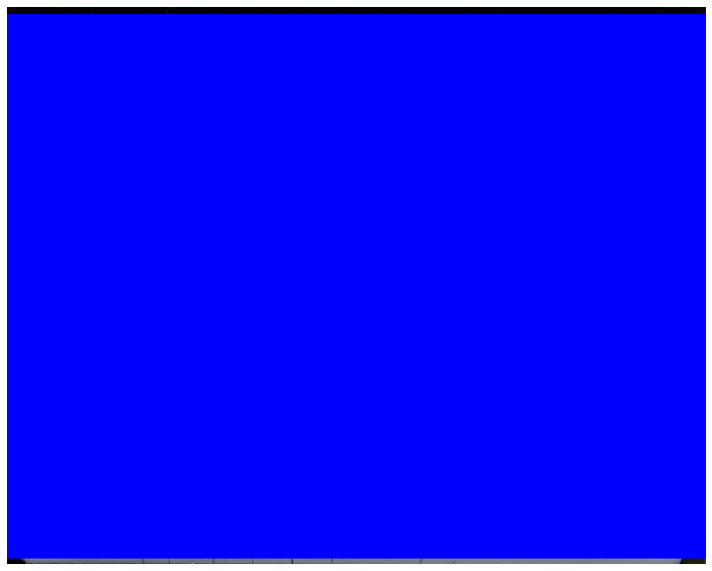

In [18]:
# np.argwhere(mask)
test_img[~nonZero] = [0,0,255]

# display_plt(skel, bw=True)
display_plt(test_img)

In [29]:
len(np.argwhere(skel == 1))
# len(test_img.flatten())

10248674

In [ ]:
len(cntsV[0])

In [ ]:
display_cv2(img)

In [ ]:
def display(img, invert=True, rotate=False, scale=3):
    #img = cv2.imread('sample.jpg')
    cv2.startWindowThread()
    cv2.imshow('img', img)

    # wait forever, if Q is pressed then close cv image window
    if cv2.waitKey(0) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
    cv2.waitKey(1)
    return 

In [ ]:
display(test_img)

In [ ]:
def display(img, invert=True, rotate=False, scale=3):
    if invert:
        img = (255-img)
    if rotate:
        img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    img = cv2.resize(img, (img.shape[1] // scale, img.shape[0] // scale), interpolation=cv2.INTER_AREA) 
    cv2.imshow('image', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    return 